In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
from random import sample
import pickle
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

## Functions

In [2]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    return pickle.load(open(filename, 'rb'))

In [3]:
def predict_evaluate(prediction, true, graphName = 'Energy Usage Prediction', showplots=False):
    
    diff = [abs(prediction[i]-true[i]) for i in range(len(prediction))]
    
    resultingPlot = plt.figure(figsize=(25,10))
    plt.plot(true, color='red', label='Original Usage')
    plt.plot(prediction, color='blue', label='Predicted Usage')
    #plt.plot(diff, color='green', label='Error')
    plt.title(graphName)
    plt.ylabel('kW')
    plt.legend()
    
    mape = mean_absolute_percentage_error(true, prediction)
    mae = mean_absolute_error(true, prediction)
    maxae = max(diff)
    mse = mean_squared_error(true, prediction)
    
    if showplots:
        plt.show()
        print("Mean Absolute Percentage Error: ", mape)
        print("Mean Absolute Error: ", mae)
        print("Max Absolute Error: ", maxae)
        print("Mean Squared Error: ", mse)
    
    #return {"name":graphName, "resultingPlot": resultingPlot, "mape":mape, "mae":mae, "maxae":maxae, "mse":mse}
    return mape

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling2D, Conv2D, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

def define_model(past_window, num_features):
    
    #OPTIMIZAVEL
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True,input_shape=(past_window, num_features)))
    model.add(LSTM(units=64))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mean_absolute_error')
    #model.summary()
    
    return model

def train(model, train_generator, showplot=False):
    early_stopping = EarlyStopping(monitor="loss", 
                                   patience=2, 
                                   mode="min")
    
    history = model.fit(train_generator, 
                                  epochs=24,
                                  shuffle = False, 
                                  callbacks=[early_stopping],
                                  verbose=0
                                   )
    
    loss_per_epoch = history.history['loss']
    
    if showplot:
        plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
        

In [5]:
featuresNames = ['use', 'hour', 'weekday']
targetName = ['use']
past_window = 24


## GENERIC MODEL

In [6]:
directory = "../../datsets/LCL_Data_Transformed/train"
trainHouses = sorted(os.listdir(directory))

In [7]:
generic_Model = load_model("generic_Model/Generic_Model.sav")
x_scaler = load_model("generic_Model/x_scaler.sav")
y_scaler = load_model("generic_Model/y_scaler.sav")

SCALER

In [ ]:
#SCALERS
x_scaler = StandardScaler()
y_scaler = StandardScaler()

d = {key:[] for key in featuresNames}
allDF = pd.DataFrame(data=d)

for filename in trainHouses:
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
        allDF = pd.concat([allDF, df[featuresNames]], ignore_index=True)

        
allFeatures = allDF[featuresNames].values
allTargets = allDF[targetName].values
        
x_scaler.fit(allFeatures)
y_scaler.fit(allTargets)

save_model(x_scaler, "generic_Model/x_scaler.sav")
save_model(y_scaler, "generic_Model/y_scaler.sav")



GENERIC MODEL

In [8]:
#generic_Model = define_model(past_window, len(featuresNames))

#Retreived already trained houses
fileTrain = open('generic_Model/trainedHouses.txt', 'r')
trainedHouses = fileTrain.readlines()
fileTrain.close()

for filename in trainHouses:
    
    #already trained
    if filename in trainedHouses:
        continue
    
    print("Training with ", filename)
    
    #Read file
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
        features = df[featuresNames].values
        target = df[targetName].values
        
        #SCALE
        x_train = x_scaler.transform(features)
        y_train = y_scaler.transform(target)
        
        #Time series
        batch_size=64
        train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
        
        train(generic_Model, train_generator)
        
        #Save model and update trained houses
        save_model(generic_Model, "generic_Model/Generic_Model.sav")
        fileTrain = open('generic_Model/trainedHouses.txt', 'a')
        fileTrain.write(filename + "\n")
        fileTrain.close() 



Training with  MAC000003.csv


INFO:tensorflow:Assets written to: ram://aee1ccf3-9e1f-4238-9e2a-00d580e73a19/assets


INFO:tensorflow:Assets written to: ram://aee1ccf3-9e1f-4238-9e2a-00d580e73a19/assets


Training with  MAC000007.csv


INFO:tensorflow:Assets written to: ram://dff25232-0a91-418c-a3f9-fbb48d2c7dc6/assets


INFO:tensorflow:Assets written to: ram://dff25232-0a91-418c-a3f9-fbb48d2c7dc6/assets


Training with  MAC000009.csv


INFO:tensorflow:Assets written to: ram://2c274f16-55ab-411d-9256-bc3d0c8e0836/assets


INFO:tensorflow:Assets written to: ram://2c274f16-55ab-411d-9256-bc3d0c8e0836/assets


Training with  MAC000010.csv


INFO:tensorflow:Assets written to: ram://9f46d6f4-08e4-4648-b759-c1047ffdef3e/assets


INFO:tensorflow:Assets written to: ram://9f46d6f4-08e4-4648-b759-c1047ffdef3e/assets


Training with  MAC000011.csv


INFO:tensorflow:Assets written to: ram://34e0cd90-298e-4208-a64d-8b82e8b945df/assets


INFO:tensorflow:Assets written to: ram://34e0cd90-298e-4208-a64d-8b82e8b945df/assets


Training with  MAC000013.csv


INFO:tensorflow:Assets written to: ram://73248456-52b7-497e-9521-803ace59579f/assets


INFO:tensorflow:Assets written to: ram://73248456-52b7-497e-9521-803ace59579f/assets


Training with  MAC000018.csv


INFO:tensorflow:Assets written to: ram://96502f4f-e5d1-478a-9035-f2ab532fabae/assets


INFO:tensorflow:Assets written to: ram://96502f4f-e5d1-478a-9035-f2ab532fabae/assets


Training with  MAC000019.csv


INFO:tensorflow:Assets written to: ram://2b3cfb89-71f0-4c1d-8be5-33c68bdc599e/assets


INFO:tensorflow:Assets written to: ram://2b3cfb89-71f0-4c1d-8be5-33c68bdc599e/assets


Training with  MAC000020.csv


INFO:tensorflow:Assets written to: ram://4b745048-dedb-4b4a-8972-9c2a24fefbcf/assets


INFO:tensorflow:Assets written to: ram://4b745048-dedb-4b4a-8972-9c2a24fefbcf/assets


Training with  MAC000021.csv


KeyboardInterrupt: 

## Case Study

In [9]:
directory = "../../datsets/LCL_Data_Transformed/test"
testHouses = sorted(os.listdir(directory))

Testing with  MAC000112.csv
GENERIC--------


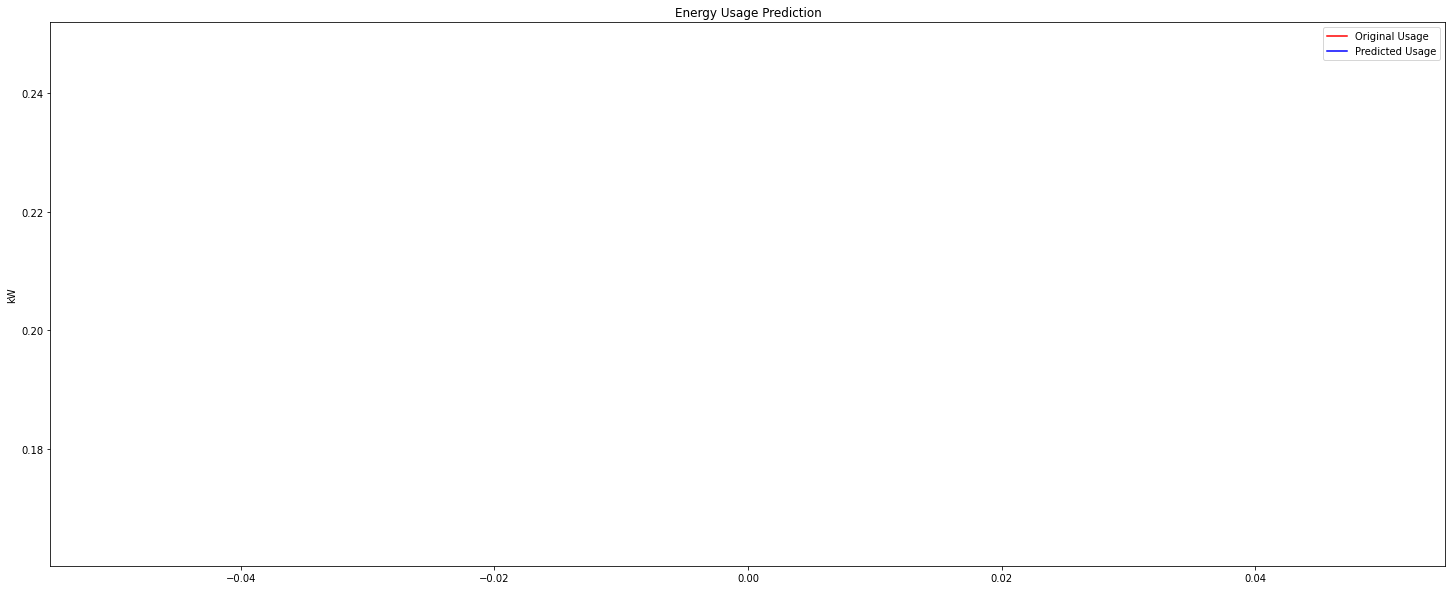

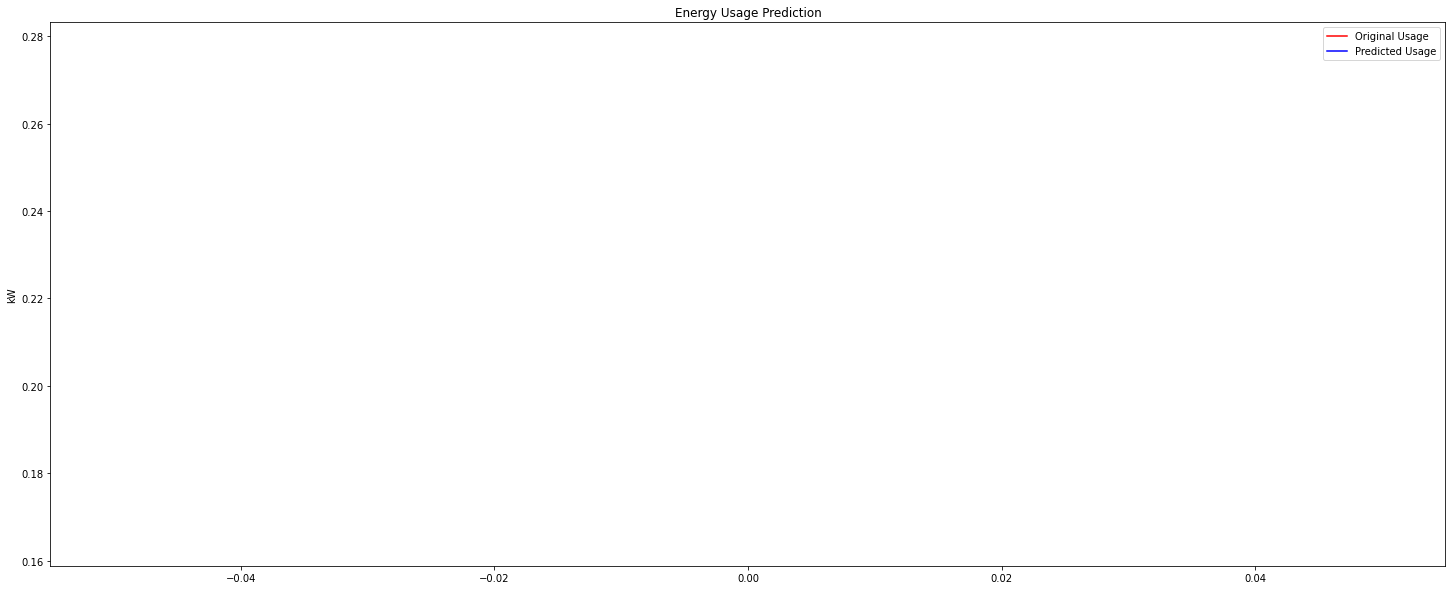

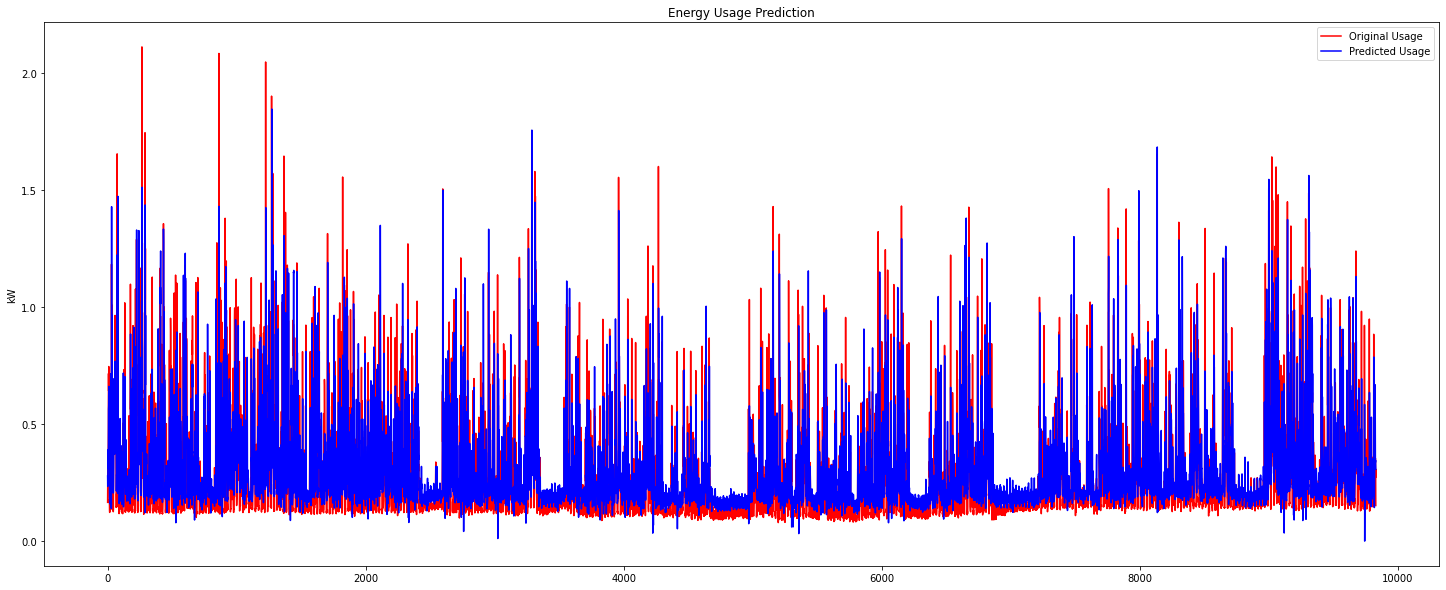

Mean Absolute Percentage Error:  0.46622680773155134
Mean Absolute Error:  0.12062654827779856
Max Absolute Error:  [1.9284242]
Mean Squared Error:  0.04063426869597186
SPECIFIC--------


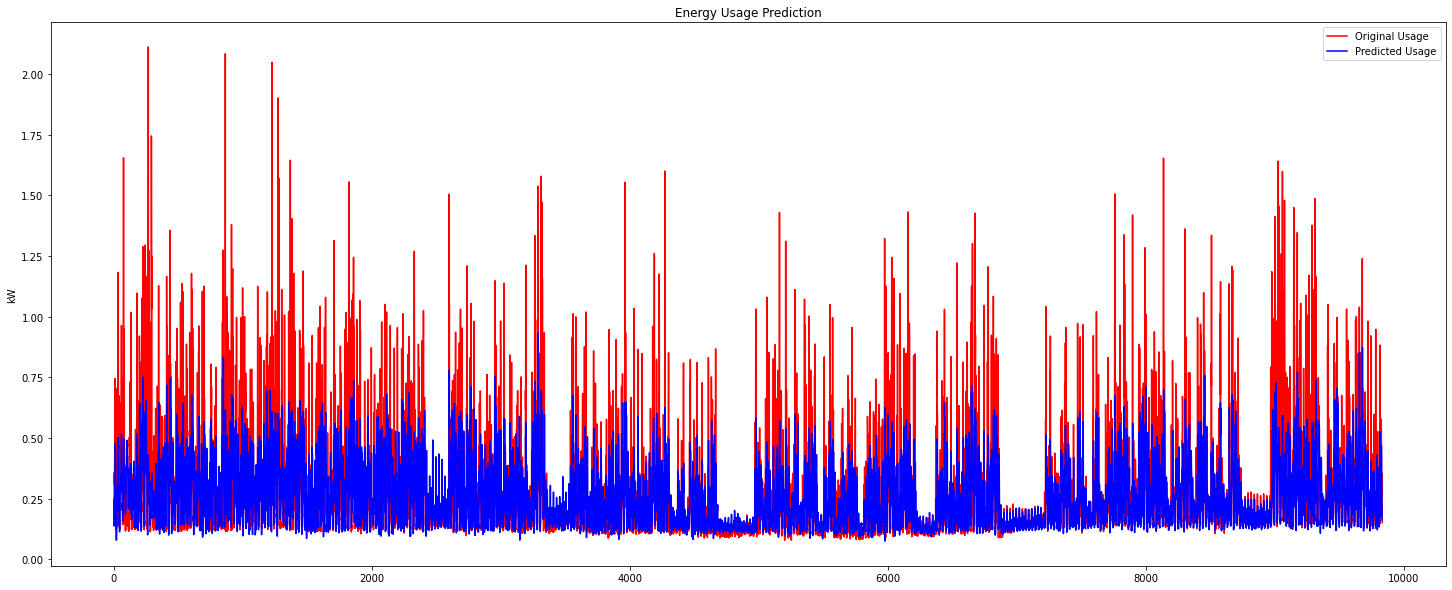

Mean Absolute Percentage Error:  0.2923415246635995
Mean Absolute Error:  0.09266489218073944
Max Absolute Error:  1.7232395606528024
Mean Squared Error:  0.030797523051341157
BEST--------


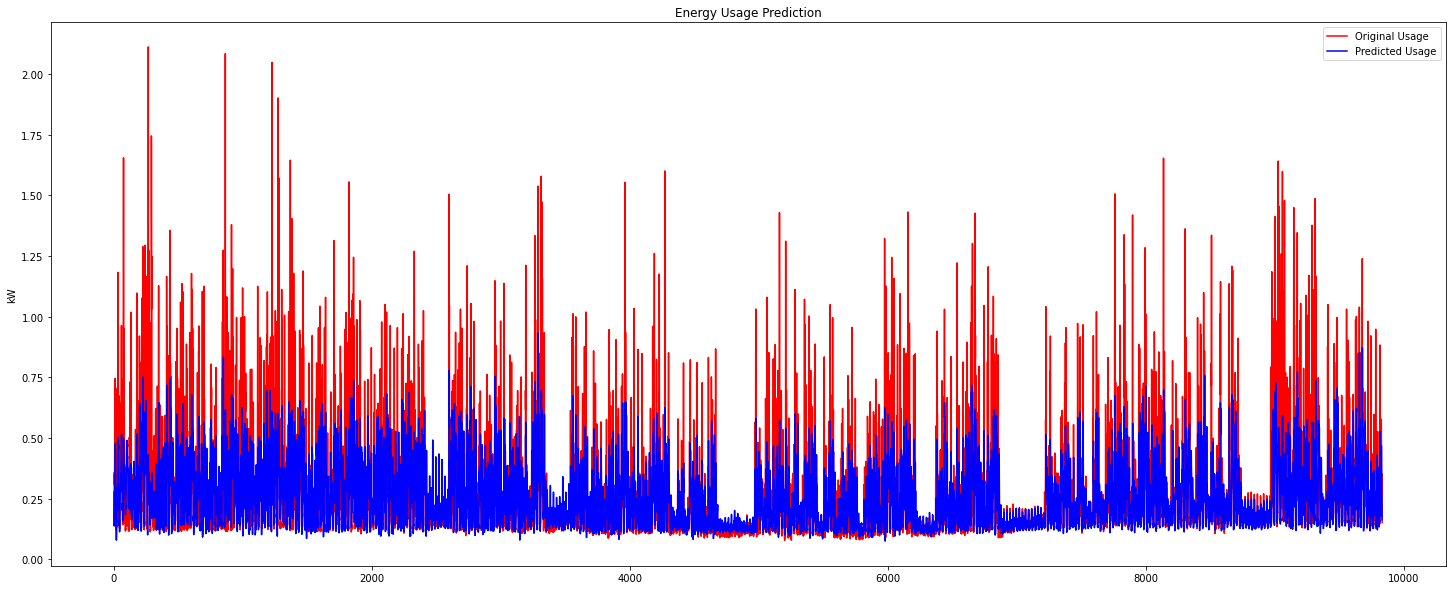

Mean Absolute Percentage Error:  0.29235996877151493
Mean Absolute Error:  0.09266792623649152
Max Absolute Error:  1.7232395606528024
Mean Squared Error:  0.030798118547519824


In [13]:
for filename in testHouses:
    print("Testing with ", filename)
    
    generic_prediction = None
    generic_preds = []

    specific_prediction = None
    specific_Model = None
    specific_preds = []
    
    best_model = "generic"
    best_preds = []
    
    true = []
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        df = df.iloc[:10000 , :]

        
    specific_x_scaler = StandardScaler()
    specific_y_scaler = StandardScaler()
    
    #new dataframe step by step
    d = {key:[] for key in df.columns}
    userKnownDf = pd.DataFrame(data=d)
    
    hourIndex = 0
    for index, row in df.iterrows():
        hourIndex += 1
        
        #Read new values
        userKnownDf = userKnownDf.append(row)
        
        if specific_Model is not None:
            
            #PREDICT NEXT
            
            #Specific Model
            #get last past_Window+1 values, the last value will get ignored by time series generator
            x_test = specific_x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
            y_test = [0 for i in range(past_window+1)] #doesnt matter
            test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)
            x_test = [arr[0].flatten() for arr in test_generator]
            
            specific_prediction = specific_y_scaler.inverse_transform(specific_Model.predict(x_test))[0]
            
            #generic Model
            x_test = x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
            y_test = [0 for i in range(past_window+1)] #doesnt matter
            test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)
            
            generic_prediction = y_scaler.inverse_transform(generic_Model.predict(test_generator))[0]    
        
            #CHECK LAST PREDICTION
            #get true value
            actualValue = row["use"]
            true.append(actualValue)
            generic_preds.append(generic_prediction)
            specific_preds.append(specific_prediction)
            
            if best_model == "generic":
                best_preds.append(generic_prediction)
                if predict_evaluate(specific_preds[-(7*24):], true[-(7*24):]) < predict_evaluate(generic_preds[-(7*24):], true[-(7*24):]):
                    best_model = "specific"
            else:
                best_preds.append(specific_prediction)
                
        #RETRAIN
        if hourIndex % (7*24) == 0:    #Every Week
            x_train = specific_x_scaler.fit_transform(userKnownDf[featuresNames].values)
            y_train = specific_y_scaler.fit_transform(userKnownDf[targetName].values.reshape(-1,1))
            train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=1)
            
            x_train = [arr[0].flatten() for arr in train_generator]
            y_train = [arr[1].flatten() for arr in train_generator]
            
            specific_Model = SVR(kernel = "rbf")
            specific_Model.fit(x_train, y_train)
        
        a = str(hourIndex) + "/" + str(len(df))
        print(a, end="\r")
    
    print("GENERIC--------")
    a = predict_evaluate(generic_preds, true, showplots=True)

    print("SPECIFIC--------")
    a = predict_evaluate(specific_preds, true, showplots=True)
    
    print("BEST--------")
    a = predict_evaluate(best_preds, true, showplots=True)
    
    break
        

## Test generic model for 1 house

In [ ]:
for filename in testHouses:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
    features = df[featuresNames].values[-(24*30-past_window):]
    target = df[targetName].values[-(24*30-past_window):]

    #SCALE
    x_test = x_scaler.transform(features)
    y_test = y_scaler.transform(target)

    #Time series
    batch_size=64
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)

    prediction = generic_Model.predict(test_generator).reshape(-1, 1)

    prediction = y_scaler.inverse_transform(prediction)


    predict_evaluate(prediction, target[past_window:], showplots=True)